# Logistic regression on the Qualitative Bankruptcy Dataset
In this notebook, I will perform logistic regression on the Qualitative Bankruptcy Dataset that can be fround [here](https://archive.ics.uci.edu/ml/datasets/Qualitative_Bankruptcy). 

Below are the attributes of the dataset. 

Attribute information: 
* P - Positive
* A - Average
* N - Negative
* B - Bankruptcy
* NB - Non-Bankruptcy

The features are

* X1 Industrial Risk: {P, A, N}
* X2 Management Risk: {P, A, N}
* X3 Financial Flexibility: {P, A, N}
* X4 Credibility: {P, A, N}
* X5 Competitiveness: {P, A, N}
* X6 Operating Risk: {P, A, N}.

The label is
* Y Class: {B, NB}.

There are 250 instances in the dataset. 

The structure of this notebook is as such:

1. Exploratory data analysis
2. Logistic regression model - fully batched gradient descent
3. Logistic regression - mini-batch stochastic gradient descent
4. Experiments

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
from scipy.io import arff
from google.colab import drive 
drive.mount('/content/gdrive')
random.seed(1234)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. Exploratory data analysis.
 In this section, I will clean and encode the dataset.

In [ ]:
# prepend headers to the csv file
qb_with_headers = open('gdrive/My Drive/College/Classes/COMP551/QB_with_headers.txt', 'w')
qb_file = open('gdrive/My Drive/College/Classes/COMP551/Qualitative_Bankruptcy.data.txt', 'r')
qb_content = qb_file.readlines()
random.shuffle(qb_content)  # shuffle the rows
qb_file.close()
qb_with_headers.write('X1,X2,X3,X4,X5,X6,Y\n')
qb_with_headers.writelines(qb_content)
qb_with_headers.close()

In [ ]:
# create dataframe
qb_df = pd.read_csv('gdrive/My Drive/College/Classes/COMP551/QB_with_headers.txt')
qb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X1      250 non-null    object
 1   X2      250 non-null    object
 2   X3      250 non-null    object
 3   X4      250 non-null    object
 4   X5      250 non-null    object
 5   X6      250 non-null    object
 6   Y       250 non-null    object
dtypes: object(7)
memory usage: 13.8+ KB


In [ ]:
qb_df.head()

,X1,X2,X3,X4,X5,X6,Y
0,N,P,A,A,A,N,NB
1,P,N,N,N,N,P,B
2,A,A,N,N,N,N,B
3,A,N,A,A,P,N,NB
4,N,N,A,P,A,N,NB


All columns have no missing data. Let's look at the distributions of the features and label. 

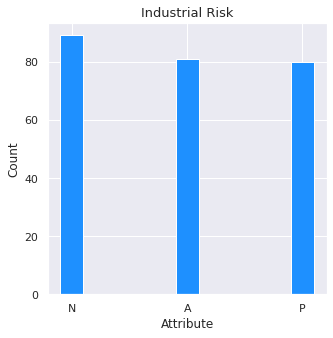

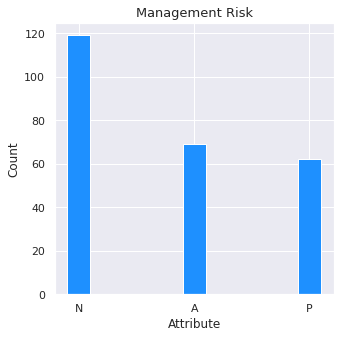

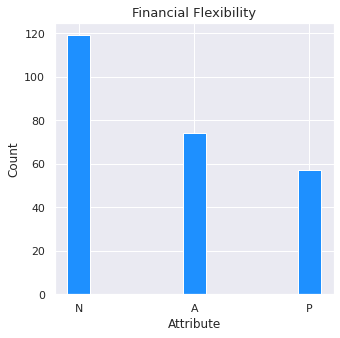

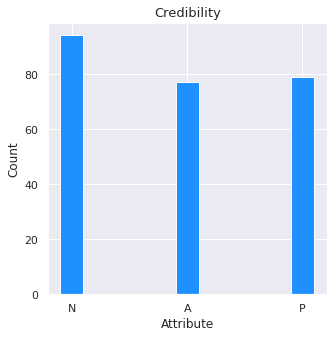

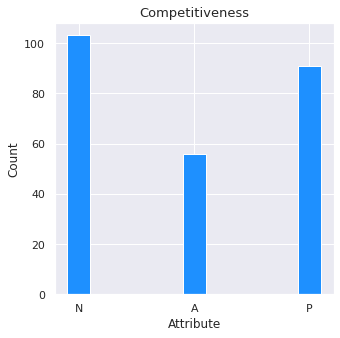

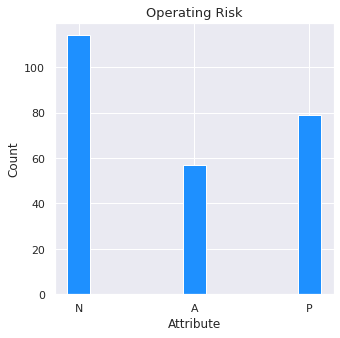

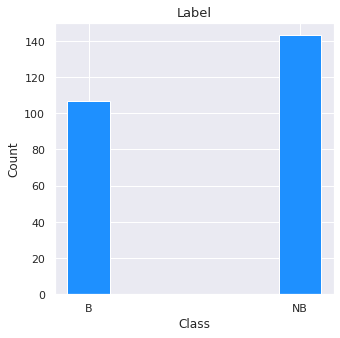

In [ ]:
columns = list(qb_df)
columns_titles = ['Industrial Risk', 'Management Risk', 'Financial Flexibility',\
                  'Credibility', 'Competitiveness', 'Operating Risk', 'Class']

sns.set(rc={'figure.figsize':(5,5)})
N = 3
ind = np.arange(N) 
width = 0.2

for i in range(len(columns)-1):

    N_count = (qb_df[columns[i]] == 'N').sum()
    A_count = (qb_df[columns[i]] == 'A').sum()
    P_count = (qb_df[columns[i]] == 'P').sum()

    bar1 = plt.bar(ind, [N_count, A_count, P_count], width, color = 'dodgerblue')

    plt.xlabel("Attribute")
    plt.ylabel('Count')
    plt.title(columns_titles[i], size=13)
    plt.xticks(ind, ['N', 'A', 'P'])
    plt.show()
  
N = 2
ind = np.arange(N) 
B_count = (qb_df['Y'] == 'B').sum()
NB_count = (qb_df['Y'] == 'NB').sum()

bar = plt.bar(ind, [B_count, NB_count], width, color = 'dodgerblue')

plt.xlabel("Class")
plt.ylabel('Count')
plt.title("Label", size=13)
plt.xticks(ind, ['B', 'NB'])
plt.show()

Now I will encode the data.
For the features, P is encoded as 3, A as 2, and N as 1.
For the label, B is encoded as 1 and NB as 0.

In [ ]:
# encode
for column in qb_df:
  qb_df[column] = qb_df[column].replace('N', 1)
  qb_df[column] = qb_df[column].replace('A', 2)
  qb_df[column] = qb_df[column].replace('P', 3)
  qb_df[column] = qb_df[column].replace('B', 1)
  qb_df[column] = qb_df[column].replace('NB', 0)


In [ ]:
qb_df.head()

,X1,X2,X3,X4,X5,X6,Y
0,1,3,2,2,2,1,0
1,3,1,1,1,1,3,1
2,2,2,1,1,1,1,1
3,2,1,2,2,3,1,0
4,1,1,2,3,2,1,0


The data look good and are ready to be used now. 

# 2. Logistic regression model - fully batched gradient descent

In this section, I will create a logistic regression model using fully batched gradient descent.

In [ ]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        # to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    # maximum number of iteration of gradient descent
        self.verbose = verbose

    def set_learnig_rate(self, lr):
        self.learning_rate = lr

    def logistic(self, z):
        return 1./ (1 + np.exp(-z))

    def gradient(self, x, y):
        N,D = x.shape
        yh = self.logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad                         # size D

    def cost_fn(self, x, y):    
        z = np.dot(x, self.w)                                                  
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
        return J
        
    def fit(self, x, y, split=0.8):
        train_size = math.trunc(len(x) * split)
        x_train, y_train = x.loc[:train_size], y.loc[:train_size].to_numpy()
        if x_train.ndim == 1:
            x_train = x_train[:, None]
        if self.add_bias:
            N = x_train.shape[0]
            x_train = np.column_stack([x_train,np.ones(N)])
        N,D = x_train.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        
        # gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x_train, y_train)
            self.w = self.w - self.learning_rate * g 
            t += 1
        self.iterations = t

        self.train_error = self.cost_fn(x_train, y_train)
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')

        return self

    def test(self, x, y, split=0.8):  # test on ((1-split)*100)% of the data
        train_size = math.trunc(len(x) * split)
        x_test, y_test = x.iloc[train_size:, :], y.loc[train_size:]
        if x_test.ndim == 1:
            x_test = x_test[:, None]  # add a dimension for the features
        N = x_test.shape[0]  # number of testing instances
        if self.add_bias:
            x_test = np.column_stack([x_test, np.ones(N)])

        yh = self.logistic(np.dot(x_test, self.w))   # predict the y values
        
        self.test_error = self.cost_fn(x_test, y_test)

        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = self.logistic(np.dot(x, self.w))            #predict output
        return yh

Let's apply the model on the dataset using 80/20 train/test split.

In [ ]:
x = qb_df.iloc[:, :6]
y = qb_df['Y']

model = LogisticRegression()
model.fit(x, y)
model.test(x, y)

In [ ]:
model.w

array([ 0.75340548, -0.29932358, -2.60037352, -2.33644803, -8.72411258,
        0.20117882, 21.65649467])

In [ ]:
print('Model performance:')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')

Model performance:
Training error: 0.0077183285029255614
Test error: 0.0056893525835002715


Let's use the predict function.

In [ ]:
toy_data = np.array([[1, 2, 3, 2, 3, 1],
                     [2, 1, 2, 1, 3, 3],
                     [1, 1, 1, 3, 1, 1],
                     [1, 1, 2, 1, 3, 1],
                     [1, 1, 1, 1, 1, 1],
                     [3, 3, 3, 3, 3, 3]])
a = model.predict(toy_data)
for item in a:
  print(f'{item}, {round(item)}')

5.970066954331334e-08, 0
3.563971518637025e-05, 0
0.9816197121429798, 1
1.1220269563197469e-05, 0
0.9998250475311073, 1
2.8868188371451854e-08, 0


# 3. Logistic regression - mini-batch stochastic gradient descent

In this section, I will implement logistic regression using mini-batch stochastic gradient descent.

In [ ]:
class LogisticRegressionMBSGD:
    
    def __init__(self, add_bias=True, learning_rate=.1, batch_size=32, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epsilon = epsilon                        # to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    # maximum number of iteration of gradient descent
        self.verbose = verbose

    def set_learnig_rate(self, lr):
        self.learning_rate = lr

    def set_batch_size(self, bs):
        self.batch_size = bs
    
    def set_max_iters(self, mi):
        self.max_iters = mi

    def logistic(self, z):
        return 1./ (1 + np.exp(-z))

    def MBSGD(self, x, y):
        N, D = x.shape
        w = np.zeros(D)  # initialize weights to zeros
        g = np.inf  # initialize gradient to infinity

        def gradient(x_batch, y_batch):
            N, D = x_batch.shape
            yh = self.logistic(np.dot(x_batch, self.w))
            grad = np.dot(x_batch.T, yh - y_batch) / N
            return grad

        num_of_batches = math.trunc(N / self.batch_size)

        t = 1
        batch_index = 0
        alpha = self.learning_rate

        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            x_mini_batch = x[batch_index * self.batch_size:batch_index * self.batch_size + self.batch_size, :]
            y_mini_batch = y[batch_index * self.batch_size:batch_index * self.batch_size + self.batch_size]
            g = gradient(x_mini_batch, y_mini_batch)
            #alpha = t ** (-0.51)
            self.w = self.w - alpha * g
            batch_index = (batch_index + 1) % num_of_batches
            t += 1

        self.iterations = t

    def cost_fn(self, x, y):    
        z = np.dot(x, self.w)                                                  
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
        return J
        
    def fit(self, x, y, split=0.8, batch_size=32):
        train_size = math.trunc(len(x) * split)
        x_train, y_train = x.loc[:train_size], y.loc[:train_size].to_numpy()
        if x_train.ndim == 1:
            x_train = x_train[:, None]
        if self.add_bias:
            N = x_train.shape[0]
            x_train = np.column_stack([x_train,np.ones(N)])
        N,D = x_train.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        
        self.MBSGD(x_train, y_train)

        yh = self.logistic(np.dot(x_train, self.w))
        self.train_error = self.cost_fn(x_train, y_train)
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')

        return self

    def test(self, x, y, split=0.8):  # test on ((1-split)*100)% of the data
        train_size = math.trunc(len(x) * split)
        x_test, y_test = x.loc[train_size:], y.loc[train_size:]
        if x_test.ndim == 1:
            x_test = x_test[:, None]  # add a dimension for the features
        N = x_test.shape[0]  # number of testing instances
        if self.add_bias:
            x_test = np.column_stack([x_test, np.ones(N)])

        yh = self.logistic(np.dot(x_test, self.w))   # predict the y values
        
        self.test_error = self.cost_fn(x_test, y_test)

        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = self.logistic(np.dot(x, self.w))            #predict output
        return yh

Let's apply the model using 80/20 train/test split.

In [ ]:
x = qb_df.iloc[:, :6]
y = qb_df['Y']

model = LogisticRegressionMBSGD()
model.fit(x, y)
model.test(x, y)

In [ ]:
model.w

array([ 0.76709892, -0.2952635 , -2.62357098, -2.33387913, -8.80736095,
        0.20103404, 21.81220186])

In [ ]:
print('Model performance:')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')

Model performance:
Training error: 0.007611167407184316
Test error: 0.005565074259992654


The model's performance is close to the performance of the model using full-batch gradient descent. Let's try out prediction.


In [ ]:
a = model.predict(toy_data)
for item in a:
  print(f'{item}, {round(item)}')

5.2066386063633656e-08, 0
3.2028076127790804e-05, 0
0.9829180266362363, 1
9.948959603181754e-06, 0
0.9998367819448635, 1
2.604023582593095e-08, 0


The predicted category for each instance is identical to the prediction of the model with full-batch gradient descent.

# 4. Experiments

In this section, I will experiment using different parameters in the model and compare the performance.

## Task 1: Performance of the linear regression model using analytical solution 

Here, I will report the performance of the fully batched logistic regression model using a 80/20 train/test split. I will report the weight of each feature and its effect on the output.

In [ ]:
x = qb_df.iloc[:, :6]
y = qb_df['Y']

model = LogisticRegression()
model.fit(x, y)
model.test(x, y)

In [ ]:
print('Model performance:')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')

Model performance:
Training error: 0.0077183285029255614
Test error: 0.0056893525835002715


The model's performances on testing is better than on training, giving cross-entropy loss of 0.0077 and 0.0057 respectively.

In [ ]:
print("Model weights")
for i in range(6):
  print(f'X{i+1} weight: {model.w[i]}')

print(f'Bias weight: {model.w[6]}')

Model weights
X1 weight: 0.7534054756023416
X2 weight: -0.2993235761445449
X3 weight: -2.60037352161135
X4 weight: -2.3364480314379037
X5 weight: -8.724112575229356
X6 weight: 0.20117881526800171
Bias weight: 21.656494673037475


X1 and X6 have positive impacts on the output, whereas X2, X3, X4, and X5 have negative impacts on the output. X5 has an especially large negative influence over the output.

## Task 2: Train/test split ratio

In this section I will change the train/test ratio and see how it affects the performance.

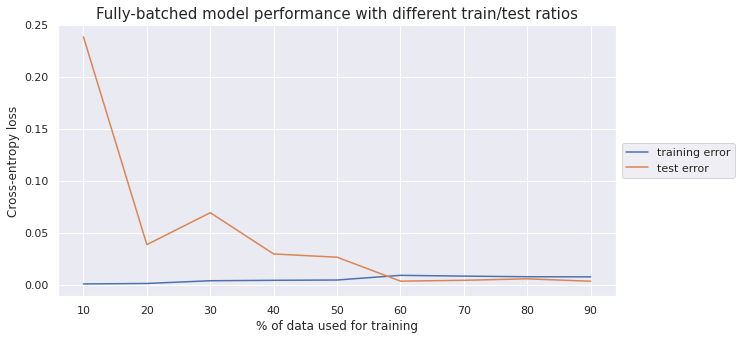

In [ ]:
x = qb_df.iloc[:, :6]
y = qb_df['Y']

model = LogisticRegression()

sns.set(rc={'figure.figsize':(10,5)})

ratios = []
train_errors = []
test_errors = []

for i in range(1, 10):
  model.fit(x, y, split=i/10)
  model.test(x, y, split=i/10)
  ratios.append(i*10)
  train_errors.append(model.train_error)
  test_errors.append(model.test_error)

plt.plot(ratios, train_errors, label = "training error")
plt.plot(ratios, test_errors, label = "test error")

plt.title("Fully-batched model performance with different train/test ratios", size=15)
plt.xlabel("% of data used for training")
plt.ylabel("Cross-entropy loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Training error is consistently low. Test erros decreases as the train/test ratio increases.

## Task 3: Different batch sizes in mini-batch stochastic gradient descent

For this task, the learning is set at 0.01 and the train/test split is set at 80/20. max_iters is set at 1000000.

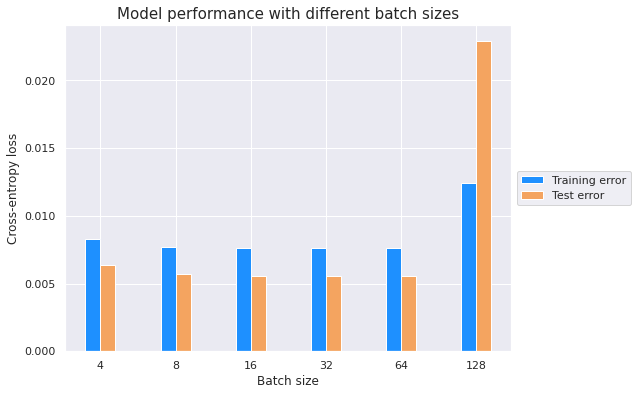

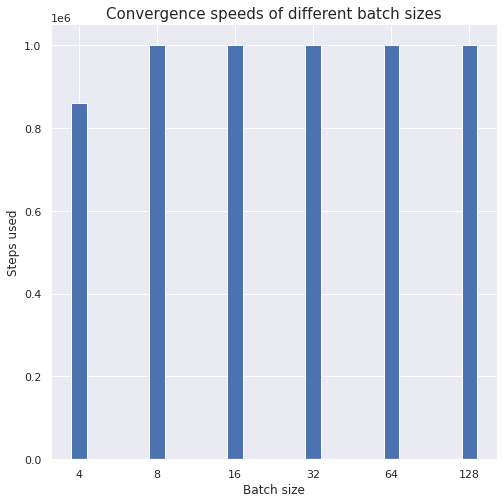

In [ ]:
x = qb_df.iloc[:, :6]
y = qb_df['Y']

model = LogisticRegressionMBSGD(learning_rate=0.01, max_iters=1000000)

batch_sizes = ["4", "8", "16", "32", "64", "128"]
train_errors = []
test_errors = []
speed = []

for bs in batch_sizes:
  model.set_batch_size(int(bs))
  model.fit(x, y)
  model.test(x, y)
  train_errors.append(model.train_error)
  test_errors.append(model.test_error)
  speed.append(model.iterations)


sns.set(rc={'figure.figsize':(8,6)})
N = 6
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), test_errors, width, color='sandybrown')

plt.xlabel("Batch size")
plt.ylabel('Cross-entropy loss')
plt.title("Model performance with different batch sizes", size=15)
plt.xticks(ind+width, batch_sizes)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

sns.set(rc={'figure.figsize':(8,8)})

bar = plt.bar(ind, speed, width)
plt.xlabel("Batch size")
plt.ylabel('Steps used')
plt.xticks(ind, batch_sizes)
plt.title("Convergence speeds of different batch sizes", size=15)
plt.show()

Both training error and test error are relatively consistent across batch sizes 8 to 64, with batch size 8 giving slightly higher errors and batch size 128 giving significantly larger error. All batch sizes except for 4 used up the maximum steps allowed.

## Task 4: Different learning rates

For this task, I will use a train/test split of 80/20. Batch size is set at 16. max_iters is 1000000.

Let's first look at the performance of the fully batched gradient descent model with different learning rates. Then let's do then same experiment on the mini-batch model. Lastly, let's compare the fully batched and mini-batched model 

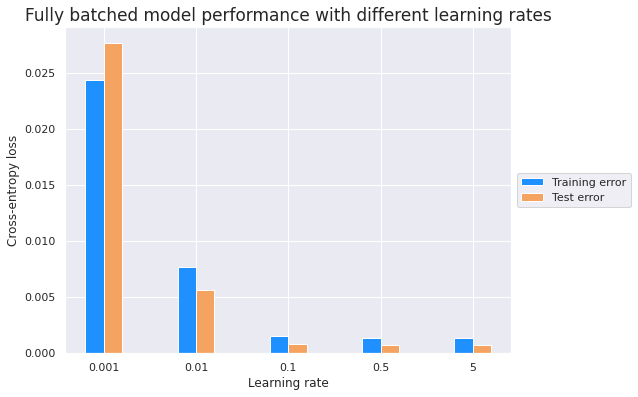

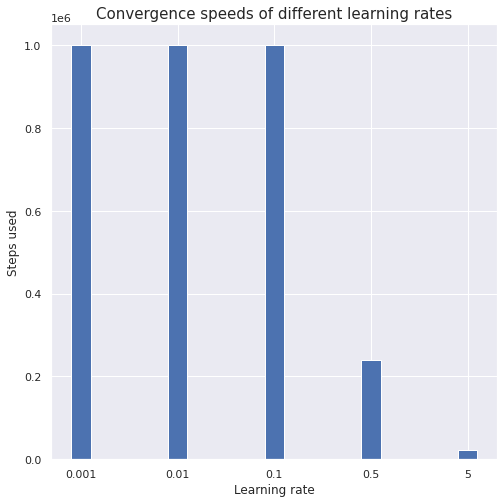

In [ ]:
x = qb_df.iloc[:, :6]
y = qb_df['Y']

model = LogisticRegression(max_iters=1000000)

learning_rates = ["0.001", "0.01", "0.1", "0.5", "5"]
train_errors = []
test_errors = []
speed = []

for lr in learning_rates:
  model.set_learnig_rate(float(lr))
  model.fit(x, y)
  model.test(x, y)
  train_errors.append(model.train_error)
  test_errors.append(model.test_error)
  speed.append(model.iterations)


sns.set(rc={'figure.figsize':(8,6)})
N = 5
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), test_errors, width, color='sandybrown')

plt.xlabel("Learning rate")
plt.ylabel('Cross-entropy loss')
plt.title("Fully batched model performance with different learning rates", size=17)
plt.xticks(ind+width, learning_rates)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

sns.set(rc={'figure.figsize':(8,8)})

bar = plt.bar(ind, speed, width)
plt.xlabel("Learning rate")
plt.ylabel('Steps used')
plt.xticks(ind, learning_rates)
plt.title("Convergence speeds of different learning rates", size=15)
plt.show()

In [ ]:
# keep a record of the errors
fb_train_errors = train_errors
fb_test_errors = test_errors
print("training errors: ",fb_train_errors)
print("test errors", fb_test_errors)

training errors:  [0.024401950111127155, 0.0077184154900777025, 0.0015852323351501722, 0.001350297380186646, 0.001350153743603994]
test errors [0.027747311233671353, 0.005689448424914502, 0.0008461186786888009, 0.0007144137494507602, 0.0007141674569910468]


Both training and test errors decrease as the learning rate increases. Learning rates 0.5 and 5 converge faster.

Now let's test the mini batch model.

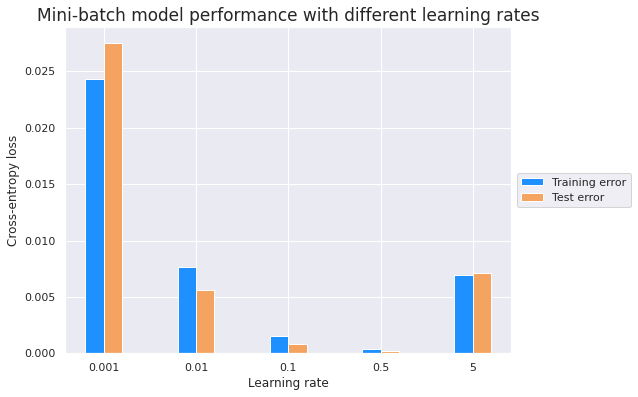

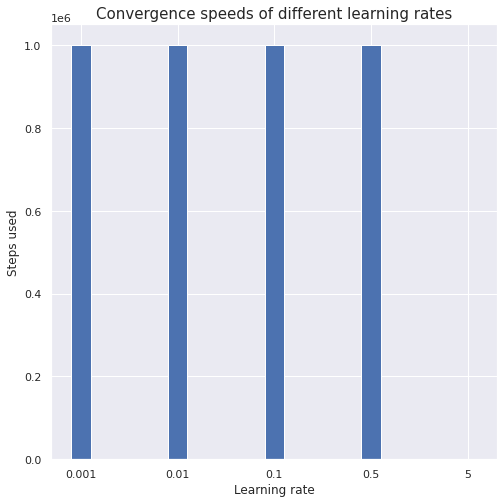

In [ ]:
model = LogisticRegressionMBSGD(max_iters=1000000)

learning_rates = ["0.001", "0.01", "0.1", "0.5", "5"]
mini_train_errors = []
mini_test_errors = []
speed = []

for lr in learning_rates:
  model.set_learnig_rate(float(lr))
  model.fit(x, y)
  model.test(x, y)
  mini_train_errors.append(model.train_error)
  mini_test_errors.append(model.test_error)
  speed.append(model.iterations)


sns.set(rc={'figure.figsize':(8,6)})
N = 5
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), mini_train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), mini_test_errors, width, color='sandybrown')

plt.xlabel("Learning rate")
plt.ylabel('Cross-entropy loss')
plt.title("Mini-batch model performance with different learning rates", size=17)
plt.xticks(ind+width, learning_rates)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

sns.set(rc={'figure.figsize':(8,8)})

bar = plt.bar(ind, speed, width)
plt.xlabel("Learning rate")
plt.ylabel('Steps used')
plt.xticks(ind, learning_rates)
plt.title("Convergence speeds of different learning rates", size=15)
plt.show()

In [ ]:
print("train errors: ", mini_train_errors)
print("test errors: ", mini_test_errors)

train errors:  [0.02433118672915809, 0.007618334653562182, 0.0015253642844224925, 0.00033832681691079824, 0.006985566972789375]
test errors:  [0.027543509658171095, 0.005574914277759365, 0.0008127891902229726, 0.00017189404840702184, 0.007097721693096162]


The errors decrease as the learning rate increases for the lower learning rates. Learning rate 5 gives higher errors as it reduces the weights by too much at each iteration. All learning rates except for 5 used up the maximum iterations allowed.

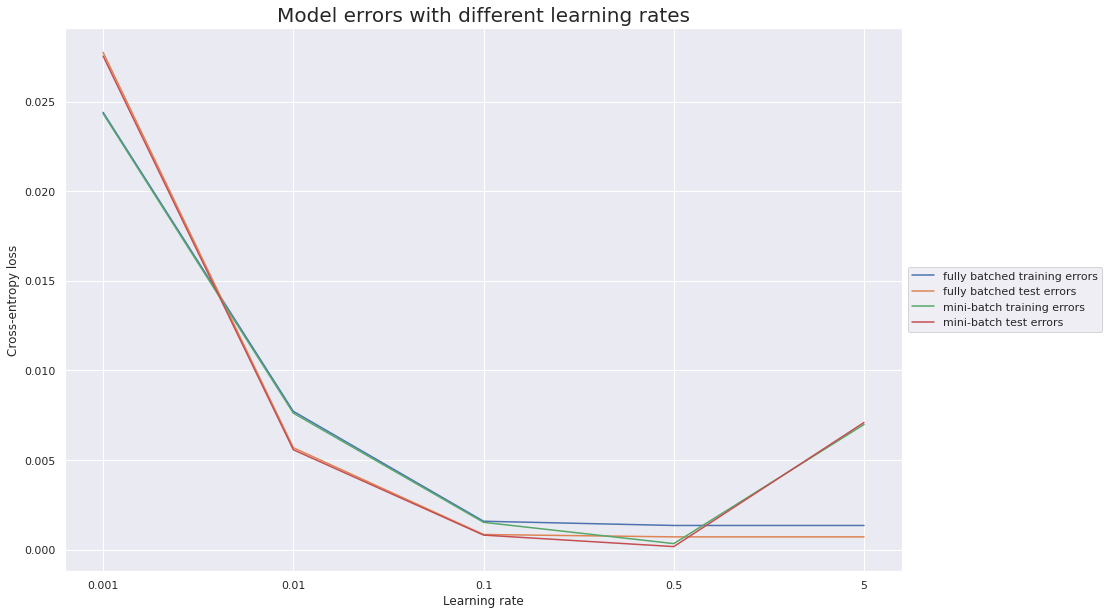

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})

plt.plot(learning_rates, fb_train_errors, label="fully batched training errors")
plt.plot(learning_rates, fb_test_errors, label="fully batched test errors")
plt.plot(learning_rates, mini_train_errors, label="mini-batch training errors")
plt.plot(learning_rates, mini_test_errors, label="mini-batch test errors")

plt.title("Model errors with different learning rates", size=20)
plt.xlabel("Learning rate")
plt.ylabel("Cross-entropy loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

From here we can see that both model have similar performances for learning rates 0.001, 0.01, and 0.1. For learning rate 0.5, mini-batch performs better. For learning rate 5, fully batched performs better.

## Task 5: Using adaptive learning rates

In this task, I will apply Adaptive Moment Estimation (ADAM) on both fully batched and mini-batch stochastic gradient dscent models.

In [ ]:
class LogisticRegressionADAM:
    
    def __init__(self, add_bias=True, learning_rate=.1, beta1=0.9, beta2=0.999, \
                 noise=1e-8, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.noise = noise
        self.epsilon = epsilon                        # to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    # maximum number of iteration of gradient descent
        self.verbose = verbose

    def set_learnig_rate(self, lr):
        self.learning_rate = lr

    def logistic(self, z):
        return 1./ (1 + np.exp(-z))

    def gradient(self, x, y):
        N,D = x.shape
        yh = self.logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad                         # size D

    def cost_fn(self, x, y):    
        z = np.dot(x, self.w)                                                  
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
        return J
        
    def fit(self, x, y, split=0.8):
        train_size = math.trunc(len(x) * split)
        x_train, y_train = x.loc[:train_size], y.loc[:train_size].to_numpy()
        if x_train.ndim == 1:
            x_train = x_train[:, None]
        if self.add_bias:
            N = x_train.shape[0]
            x_train = np.column_stack([x_train,np.ones(N)])
        
        N,D = x_train.shape
        self.w = np.zeros(D)
        g = np.inf 
        m  = 0
        v = 0
        t = 0
        alpha = self.learning_rate
        
        # gradient descent with ADAM
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            t += 1
            g = self.gradient(x_train, y_train)
            m = self.beta1 * m + (1 - self.beta1) * g
            v = self.beta2 * v + (1 - self.beta2) * (g ** 2)
            m_hat = m / (1 - self.beta1 ** t)
            v_hat = v / (1 - self.beta2 ** t)
            self.w = self.w - alpha * m_hat / (np.square(v_hat) + self.noise)

        self.iterations = t

        self.train_error = self.cost_fn(x_train, y_train)
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')

        return self

    def test(self, x, y, split=0.8):  # test on ((1-split)*100)% of the data
        train_size = math.trunc(len(x) * split)
        x_test, y_test = x.iloc[train_size:, :], y.loc[train_size:]
        if x_test.ndim == 1:
            x_test = x_test[:, None]  # add a dimension for the features
        N = x_test.shape[0]  # number of testing instances
        if self.add_bias:
            x_test = np.column_stack([x_test, np.ones(N)])

        yh = self.logistic(np.dot(x_test, self.w))   # predict the y values
        
        self.test_error = self.cost_fn(x_test, y_test)

        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = self.logistic(np.dot(x, self.w))            #predict output
        return yh

In [ ]:
class LogisticRegressionMBSGD_ADAM:
    
    def __init__(self, add_bias=True, learning_rate=.1, batch_size=32, beta1=0.9, \
                 beta2=0.999, noise=1e-8, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.beta1 = beta1
        self.beta2 = beta2
        self.noise = noise
        self.epsilon = epsilon                        # to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    # maximum number of iteration of gradient descent
        self.verbose = verbose

    def set_learnig_rate(self, lr):
        self.learning_rate = lr

    def set_batch_size(self, bs):
        self.batch_size = bs
    
    def set_max_iters(self, mi):
        self.max_iters = mi

    def logistic(self, z):
        return 1./ (1 + np.exp(-z))

    def MBSGD(self, x, y):
        N, D = x.shape
        self.w = np.zeros(D)  # initialize weights to zeros
        g = np.inf  # initialize gradient to infinity
        m  = 0
        v = 0
        t = 0
        alpha = self.learning_rate

        def gradient(x_batch, y_batch):
            N, D = x_batch.shape
            yh = self.logistic(np.dot(x_batch, self.w))
            grad = np.dot(x_batch.T, yh - y_batch) / N
            return grad

        num_of_batches = math.trunc(N / self.batch_size)
        batch_index = 0

        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            t += 1
            x_mini_batch = x[batch_index * self.batch_size:batch_index * self.batch_size + self.batch_size, :]
            y_mini_batch = y[batch_index * self.batch_size:batch_index * self.batch_size + self.batch_size]
            g = gradient(x_mini_batch, y_mini_batch)
            m = self.beta1 * m + (1 - self.beta1) * g
            v = self.beta2 * v + (1 - self.beta2) * (g ** 2)
            m_hat = m / (1 - self.beta1 ** t)
            v_hat = v / (1 - self.beta2 ** t)
            self.w = self.w - alpha * m_hat / (np.square(v_hat) + self.noise)
            batch_index = (batch_index + 1) % num_of_batches

        self.iterations = t

    def cost_fn(self, x, y):    
        z = np.dot(x, self.w)                                                  
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
        return J
        
    def fit(self, x, y, split=0.8, batch_size=32):
        train_size = math.trunc(len(x) * split)
        x_train, y_train = x.loc[:train_size], y.loc[:train_size].to_numpy()
        if x_train.ndim == 1:
            x_train = x_train[:, None]
        if self.add_bias:
            N = x_train.shape[0]
            x_train = np.column_stack([x_train,np.ones(N)])
        N,D = x_train.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        
        self.MBSGD(x_train, y_train)

        self.train_error = self.cost_fn(x_train, y_train)
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')

        return self

    def test(self, x, y, split=0.8):  # test on ((1-split)*100)% of the data
        train_size = math.trunc(len(x) * split)
        x_test, y_test = x.loc[train_size:], y.loc[train_size:]
        if x_test.ndim == 1:
            x_test = x_test[:, None]  # add a dimension for the features
        N = x_test.shape[0]  # number of testing instances
        if self.add_bias:
            x_test = np.column_stack([x_test, np.ones(N)])
        
        self.test_error = self.cost_fn(x_test, y_test)

        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = self.logistic(np.dot(x, self.w))            #predict output
        return yh

Let's compare the four models:
* Fully batched gradient descent
* Fully batched gradient descent with ADAM
* Mini-batch stochastic gradient descent
* Mini-batch stochastic gradient descent with ADAM

The hyperparameters are as such:
* train/test ratio: 80/20
* learning rate: 0.1
* batch size: 16
* beta 1: 0.9
* beta 2: 0.999
* noise: 1e-8
* maximum iterations allowed: 1000000

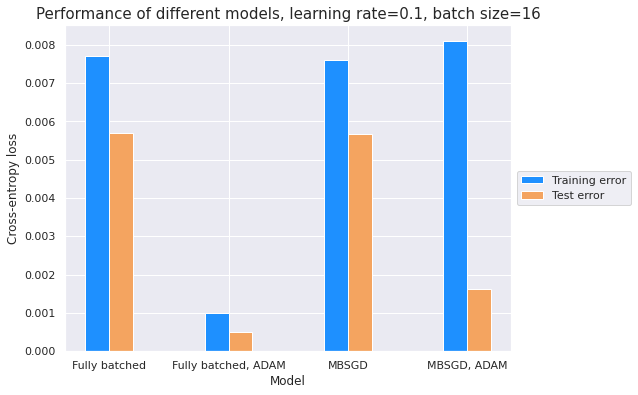

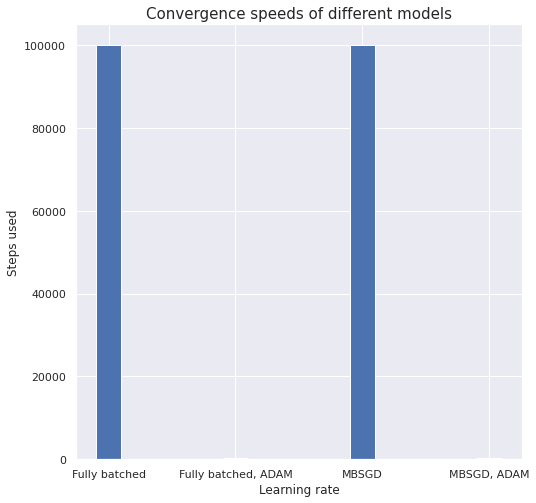

In [ ]:
x = qb_df.iloc[:, :6]
y = qb_df['Y']

solutions = ['Fully batched', 'Fully batched, ADAM', 'MBSGD', 'MBSGD, ADAM']
train_errors = []
test_errors = []
speed = []

# Logistic regression with fully batched gradient descent, no ADAM
model_fb = LogisticRegression()
model_fb.fit(x, y)
model_fb.test(x, y)
train_errors.append(model_fb.train_error)
test_errors.append(model_fb.test_error)
speed.append(model_fb.iterations)

# Logistic regression with fully batched gradient descent, with ADAM
model_fb_ADAM = LogisticRegressionADAM()
model_fb_ADAM.fit(x, y)
model_fb_ADAM.test(x, y)
train_errors.append(model_fb_ADAM.train_error)
test_errors.append(model_fb_ADAM.test_error)
speed.append(model_fb_ADAM.iterations)

# Logistic regression with MBSGD, no ADAM
model_mini = LogisticRegressionMBSGD(batch_size=16)
model_mini.fit(x, y)
model_mini.test(x, y)
train_errors.append(model_mini.train_error)
test_errors.append(model_mini.test_error)
speed.append(model_mini.iterations)

# Logistic regression with MBSGD, with ADAM
model_mini_ADAM = LogisticRegressionMBSGD_ADAM(batch_size=16)
model_mini_ADAM.fit(x, y)
model_mini_ADAM.test(x, y)
train_errors.append(model_mini_ADAM.train_error)
test_errors.append(model_mini_ADAM.test_error)
speed.append(model_mini_ADAM.iterations)

# plot
sns.set(rc={'figure.figsize':(8,6)})
N = 4
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), test_errors, width, color='sandybrown')

plt.xlabel("Model")
plt.ylabel('Cross-entropy loss')
plt.title("Performance of different models, learning rate=0.1, batch size=16", size=15)
plt.xticks(ind+width, solutions)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

sns.set(rc={'figure.figsize':(8,8)})

bar = plt.bar(ind, speed, width)
plt.xlabel("Learning rate")
plt.ylabel('Steps used')
plt.xticks(ind, solutions)
plt.title("Convergence speeds of different models", size=15)
plt.show()

We can see that the models using ADAM converge much faster. The best model in this cnfiguration of hyperparamters is the fully batched model with ADAM.